In [14]:
import pandas as pd

# Load CSV
df = pd.read_csv("/content/rain_prediction.csv")

# Show first 5 rows
df.head()


,Date,Location,Temperature,Humidity,Wind Speed,Precipitation,Cloud Cover,Pressure,Rain Tomorrow
0,2024-01-01,New York,87.524795,75.655455,28.379506,0.000000,69.617966,1026.030278,0
1,2024-01-02,New York,83.259325,28.712617,12.436433,0.526995,41.606048,995.962065,0
2,2024-01-03,New York,80.943050,64.740043,14.184831,0.916884,77.364763,980.796739,1
3,2024-01-04,New York,78.097552,59.738984,19.444029,0.094134,52.541196,979.012163,0
4,2024-01-05,New York,37.059963,34.766784,3.689661,1.361272,85.584000,1031.790859,0


In [15]:
# Dataset size
print(df.shape)

# Column types and missing values
print(df.info())

# Summary statistics
print(df.describe())

# Count missing values
print(df.isnull().sum())


(73100, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73100 entries, 0 to 73099
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           73100 non-null  object 
 1   Location       73100 non-null  object 
 2   Temperature    73100 non-null  float64
 3   Humidity       73100 non-null  float64
 4   Wind Speed     73100 non-null  float64
 5   Precipitation  73100 non-null  float64
 6   Cloud Cover    73100 non-null  float64
 7   Pressure       73100 non-null  float64
 8   Rain Tomorrow  73100 non-null  int64  
dtypes: float64(6), int64(1), object(2)
memory usage: 5.0+ MB
None
        Temperature      Humidity    Wind Speed  Precipitation   Cloud Cover  \
count  73100.000000  73100.000000  73100.000000   73100.000000  73100.000000   
mean      65.182270     59.875041     15.017946       0.390635     54.942807   
std       20.205793     23.066115      8.668729       0.474833     25.982487   
min       

In [6]:
# Fill numerical columns with mean
num_cols = ['Temperature', 'Humidity', 'Wind Speed', 'Precipitation', 'Cloud Cover', 'Pressure']
for col in num_cols:
    df[col].fillna(df[col].mean(), inplace=True)

# Fill categorical columns with mode (if needed)
df['Location'].fillna(df['Location'].mode()[0], inplace=True)
df['Rain Tomorrow'].fillna(df['Rain Tomorrow'].mode()[0], inplace=True)


/tmp/ipython-input-4071574519.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mean(), inplace=True)
/tmp/ipython-input-4071574519.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 

In [7]:
from sklearn.preprocessing import LabelEncoder

# 'Rain Tomorrow' is already 0/1, no need to encode
# Encode 'Location' using One-Hot Encoding
df = pd.get_dummies(df, columns=['Location'])


In [8]:
df['Date'] = pd.to_datetime(df['Date'])

# Extract month, day, weekday
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Weekday'] = df['Date'].dt.weekday

# Drop original Date column if not needed
df.drop('Date', axis=1, inplace=True)


In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])


In [10]:
X = df.drop('Rain Tomorrow', axis=1)
y = df['Rain Tomorrow']


In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [12]:
print("\nPreprocessing complete!")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


Preprocessing complete!
X_train shape: (58480, 29)
X_test shape: (14620, 29)
y_train shape: (58480,)
y_test shape: (14620,)


In [16]:
import pandas as pd
import numpy as np

# Visuals
import matplotlib.pyplot as plt
import seaborn as sns

# ML utilities
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

# Load CSV
df = pd.read_csv("/content/rain_prediction.csv")
df.head()


,Date,Location,Temperature,Humidity,Wind Speed,Precipitation,Cloud Cover,Pressure,Rain Tomorrow
0,2024-01-01,New York,87.524795,75.655455,28.379506,0.000000,69.617966,1026.030278,0
1,2024-01-02,New York,83.259325,28.712617,12.436433,0.526995,41.606048,995.962065,0
2,2024-01-03,New York,80.943050,64.740043,14.184831,0.916884,77.364763,980.796739,1
3,2024-01-04,New York,78.097552,59.738984,19.444029,0.094134,52.541196,979.012163,0
4,2024-01-05,New York,37.059963,34.766784,3.689661,1.361272,85.584000,1031.790859,0


In [17]:
# Shape, types, missingness
print("Shape:", df.shape)
print("\nInfo:")
print(df.info())
print("\nMissing values:")
print(df.isnull().sum())

# Quick stats for numeric columns
num_cols_raw = ['Temperature','Humidity','Wind Speed','Precipitation','Cloud Cover','Pressure']
df[num_cols_raw].describe()


Shape: (73100, 9)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73100 entries, 0 to 73099
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           73100 non-null  object 
 1   Location       73100 non-null  object 
 2   Temperature    73100 non-null  float64
 3   Humidity       73100 non-null  float64
 4   Wind Speed     73100 non-null  float64
 5   Precipitation  73100 non-null  float64
 6   Cloud Cover    73100 non-null  float64
 7   Pressure       73100 non-null  float64
 8   Rain Tomorrow  73100 non-null  int64  
dtypes: float64(6), int64(1), object(2)
memory usage: 5.0+ MB
None

Missing values:
Date             0
Location         0
Temperature      0
Humidity         0
Wind Speed       0
Precipitation    0
Cloud Cover      0
Pressure         0
Rain Tomorrow    0
dtype: int64


,Temperature,Humidity,Wind Speed,Precipitation,Cloud Cover,Pressure
count,73100.000000,73100.000000,73100.000000,73100.000000,73100.000000,73100.000000
mean,65.182270,59.875041,15.017946,0.390635,54.942807,1005.176013
std,20.205793,23.066115,8.668729,0.474833,25.982487,20.203889
min,30.000766,20.000272,0.000712,0.000000,10.000856,970.000919
25%,47.678968,39.800732,7.485182,0.000000,32.318668,987.697646
50%,65.294949,59.887840,15.102495,0.196909,55.011121,1005.284188
75%,82.636570,79.835990,22.551794,0.673177,77.412469,1022.727410
max,99.997393,99.999025,29.999017,3.078090,99.998957,1039.999765


Rain Tomorrow
0    56988
1    16112
Name: count, dtype: int64


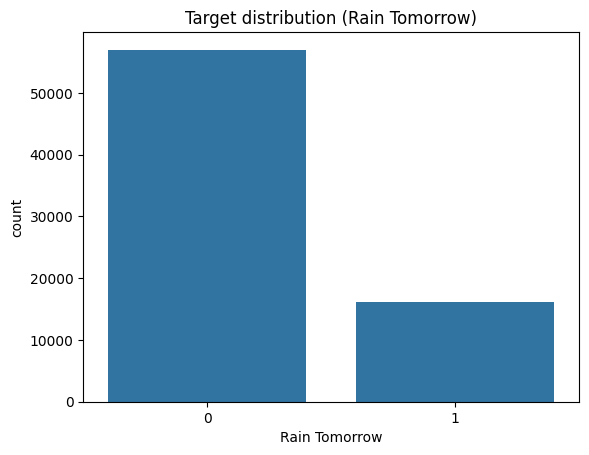

In [18]:
# Parse Date and create simple date features (for EDA views)
df['Date'] = pd.to_datetime(df['Date'])
df['Month']   = df['Date'].dt.month
df['Day']     = df['Date'].dt.day
df['Weekday'] = df['Date'].dt.weekday

# Target balance
print(df['Rain Tomorrow'].value_counts(dropna=False))

# Plot target distribution
sns.countplot(x='Rain Tomorrow', data=df)
plt.title('Target distribution (Rain Tomorrow)')
plt.show()


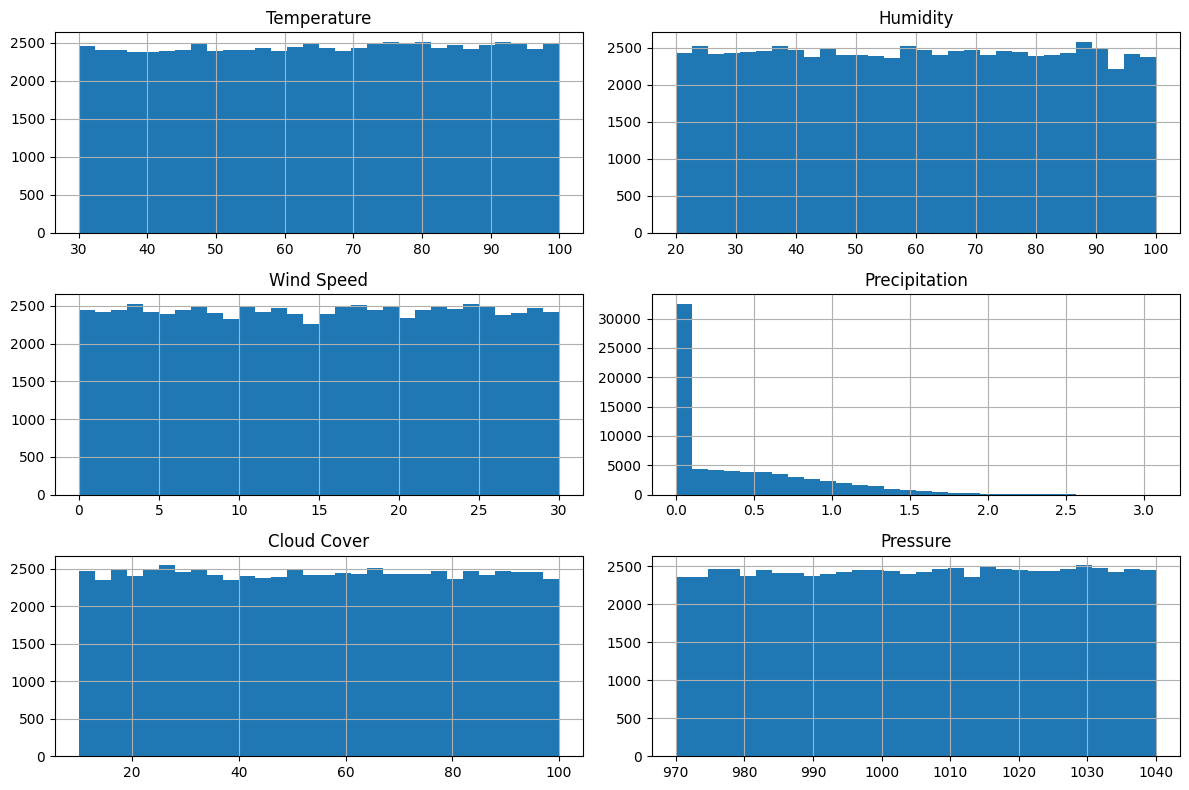

In [19]:
# Histograms for numerics
df[num_cols_raw].hist(bins=30, figsize=(12,8))
plt.tight_layout()
plt.show()


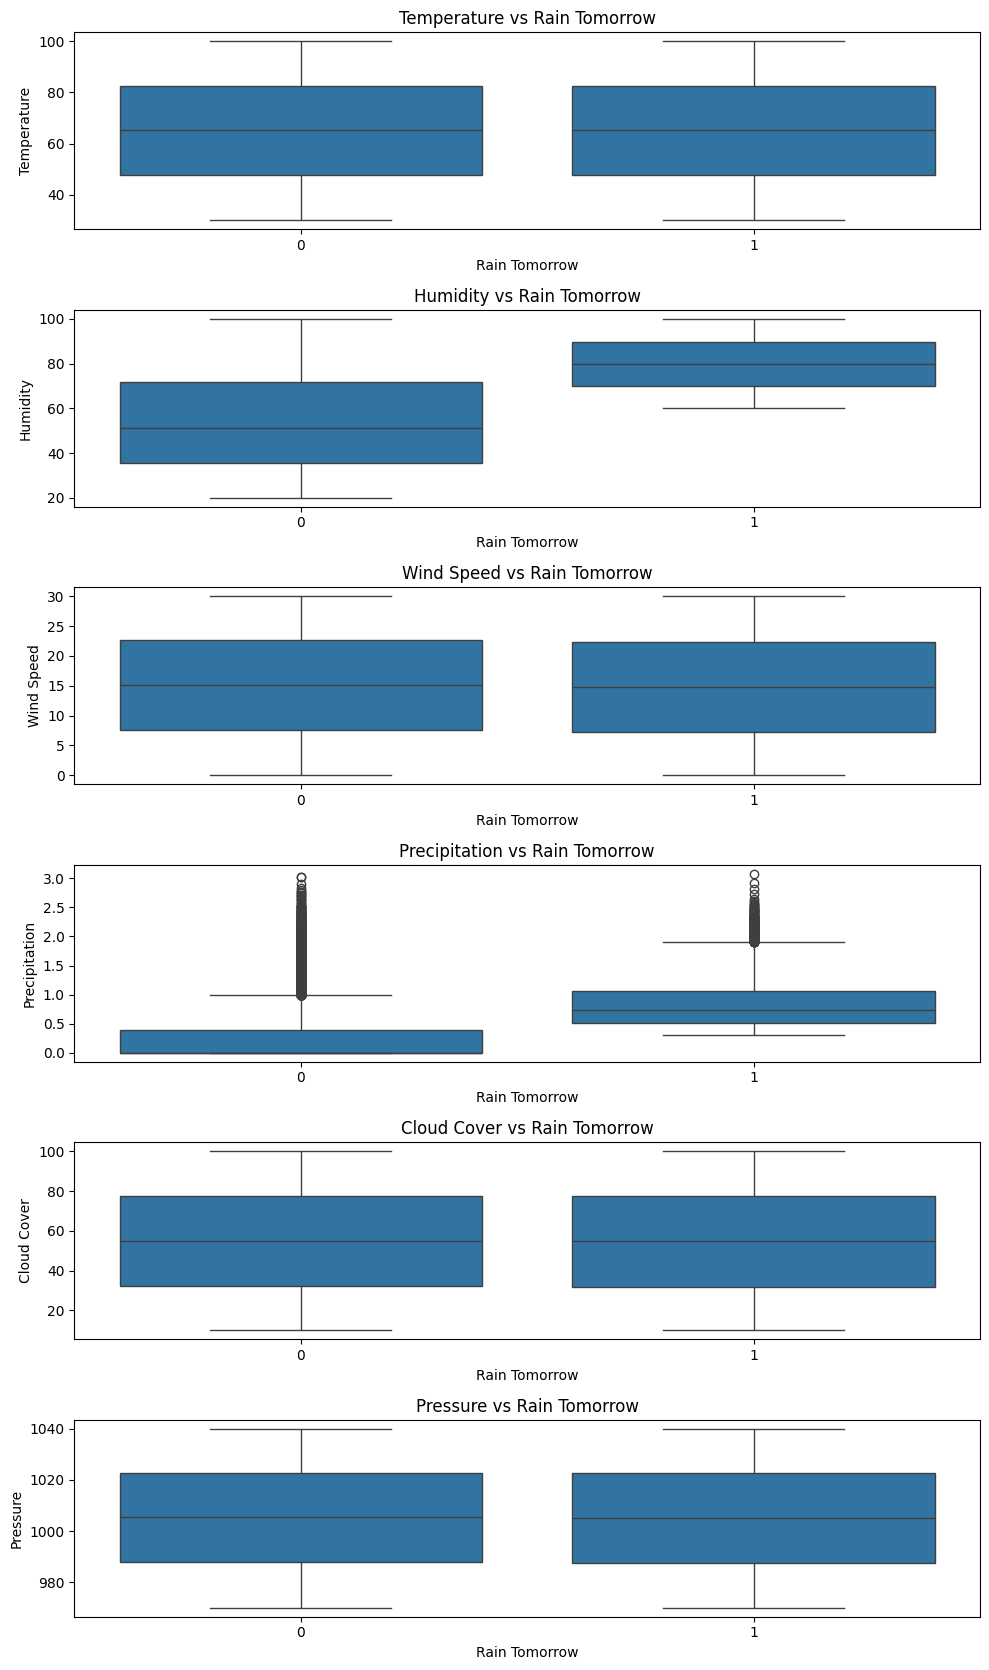

In [20]:
# Boxplots of numerics by target (spot differences & outliers)
fig, axes = plt.subplots(nrows=len(num_cols_raw), ncols=1, figsize=(10, 2.8*len(num_cols_raw)))
for i, c in enumerate(num_cols_raw):
    sns.boxplot(x='Rain Tomorrow', y=c, data=df, ax=axes[i])
    axes[i].set_title(f'{c} vs Rain Tomorrow')
plt.tight_layout()
plt.show()


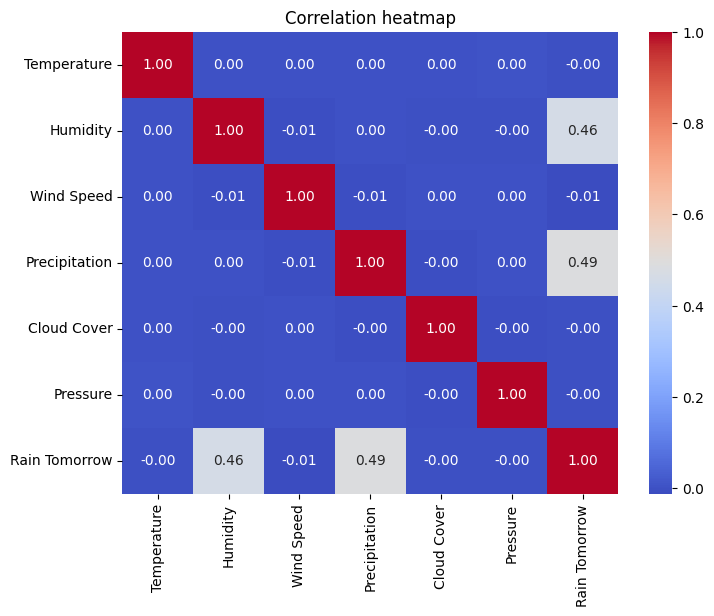

In [21]:
# Correlation (numeric + target; since target is 0/1, Pearson can hint at linear relation)
corr = df[num_cols_raw + ['Rain Tomorrow']].corr(numeric_only=True)
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation heatmap')
plt.show()


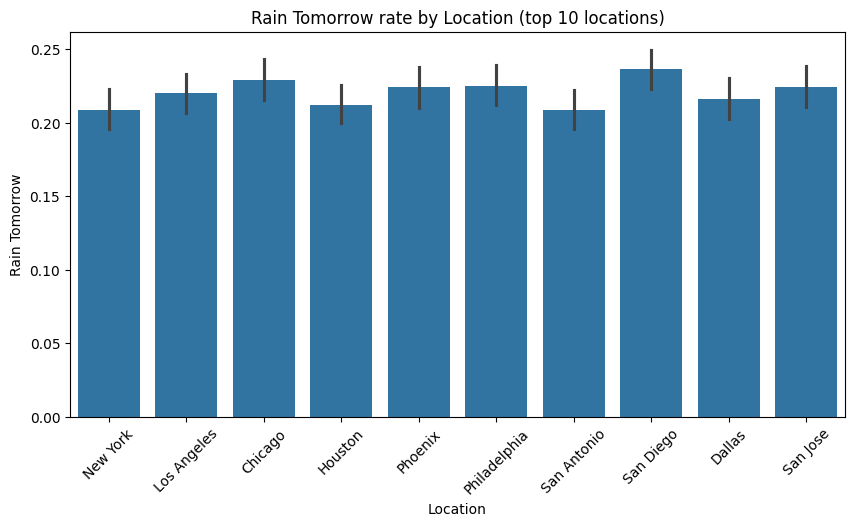

In [22]:
# How weather differs by Location (top 10)
top_locs = df['Location'].value_counts().head(10).index
df_top = df[df['Location'].isin(top_locs)]
plt.figure(figsize=(10,5))
sns.barplot(x='Location', y='Rain Tomorrow', data=df_top, estimator=np.mean, order=top_locs)
plt.title('Rain Tomorrow rate by Location (top 10 locations)')
plt.xticks(rotation=45)
plt.show()


In [23]:
# Make a working copy and add date features (drop raw Date after extraction)
df_work = df.copy()
df_work['Date'] = pd.to_datetime(df_work['Date'])
df_work['Month']   = df_work['Date'].dt.month
df_work['Day']     = df_work['Date'].dt.day
df_work['Weekday'] = df_work['Date'].dt.weekday
df_work = df_work.drop(columns=['Date'])

# Define columns
numeric_features = ['Temperature','Humidity','Wind Speed','Precipitation','Cloud Cover','Pressure',
                    'Month','Day','Weekday']
categorical_features = ['Location']
target_col = 'Rain Tomorrow'

# Split BEFORE fitting any transformers (to avoid leakage)
X = df_work.drop(columns=[target_col])
y = df_work[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Transformers
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler',  StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot',  OneHotEncoder(handle_unknown='ignore'))
])

# ColumnTransformer (preprocessor)
preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'
)

# Fit the preprocessor on TRAIN only and transform both sets
X_train_proc = preprocess.fit_transform(X_train)
X_test_proc  = preprocess.transform(X_test)

# Get feature names after preprocessing (useful for feature selection introspection)
feature_names = preprocess.get_feature_names_out()
print("Processed feature matrix shapes:", X_train_proc.shape, X_test_proc.shape)
print("Example features:", feature_names[:15])


Processed feature matrix shapes: (58480, 29) (14620, 29)
Example features: ['num__Temperature' 'num__Humidity' 'num__Wind Speed' 'num__Precipitation'
 'num__Cloud Cover' 'num__Pressure' 'num__Month' 'num__Day' 'num__Weekday'
 'cat__Location_Austin' 'cat__Location_Charlotte' 'cat__Location_Chicago'
 'cat__Location_Columbus' 'cat__Location_Dallas' 'cat__Location_Denver']


In [24]:
from sklearn.feature_selection import SelectKBest

k = min(15, X_train_proc.shape[1])  # choose up to 15 or total features if fewer
selector = SelectKBest(score_func=mutual_info_classif, k=k)
selector.fit(X_train_proc, y_train)

mi_scores = pd.Series(selector.scores_, index=feature_names).sort_values(ascending=False)
print("Top features by Mutual Information:")
display(mi_scores.head(20))

# Which features were selected?
selected_mask = selector.get_support()
selected_features_mi = feature_names[selected_mask]
print("\nSelected features (MI):")
print(selected_features_mi)


Top features by Mutual Information:


,0
num__Precipitation,0.222734
num__Humidity,0.183583
num__Cloud Cover,0.004171
cat__Location_New York,0.003129
num__Pressure,0.002166
cat__Location_Houston,0.001956
cat__Location_San Francisco,0.001938
cat__Location_Fort Worth,0.001752
num__Weekday,0.001508
cat__Location_Chicago,0.001357



Selected features (MI):
['num__Humidity' 'num__Precipitation' 'num__Cloud Cover' 'num__Pressure'
 'num__Month' 'num__Weekday' 'cat__Location_Austin'
 'cat__Location_Chicago' 'cat__Location_Fort Worth'
 'cat__Location_Houston' 'cat__Location_Los Angeles'
 'cat__Location_New York' 'cat__Location_San Antonio'
 'cat__Location_San Francisco' 'cat__Location_San Jose']


Top features by RandomForest feature_importances_:


,0
num__Precipitation,0.506020
num__Humidity,0.458199
num__Wind Speed,0.005796
num__Temperature,0.005672
num__Pressure,0.005621
num__Cloud Cover,0.005561
num__Day,0.003711
num__Month,0.002736
num__Weekday,0.002212
cat__Location_Washington D.C.,0.000241


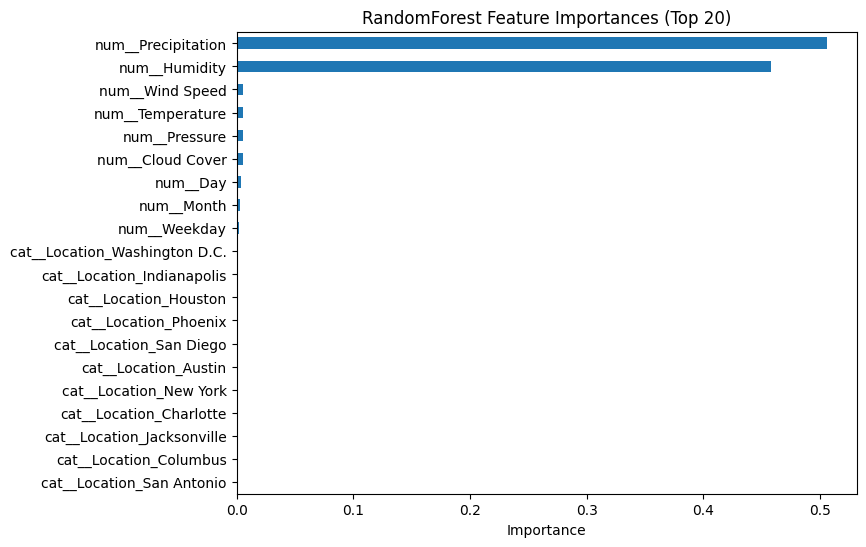

In [25]:
rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

# Fit on preprocessed training data
rf.fit(X_train_proc, y_train)

# Importances
importances = pd.Series(rf.feature_importances_, index=feature_names).sort_values(ascending=False)
print("Top features by RandomForest feature_importances_:")
display(importances.head(20))

# Plot top 20
top20 = importances.head(20)
plt.figure(figsize=(8,6))
top20[::-1].plot(kind='barh')
plt.title('RandomForest Feature Importances (Top 20)')
plt.xlabel('Importance')
plt.show()


In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

# A complete training pipeline: preprocess -> select -> model
pipe = Pipeline(steps=[
    ('preprocess', preprocess),
    ('select', SelectKBest(mutual_info_classif, k=15)),
    ('model', LogisticRegression(max_iter=1000))
])

pipe.fit(X_train, y_train)
print("Train accuracy:", pipe.score(X_train, y_train))
print("Test  accuracy:", pipe.score(X_test, y_test))


Train accuracy: 0.9043946648426813
Test  accuracy: 0.9075239398084816


In [29]:
# Save MI and RF top features for your report
mi_top = mi_scores.head(20).index.tolist()
rf_top = importances.head(20).index.tolist()
print("Top 20 MI features:", mi_top)
print("Top 20 RF features:", rf_top)


Top 20 MI features: ['num__Precipitation', 'num__Humidity', 'num__Cloud Cover', 'cat__Location_New York', 'num__Pressure', 'cat__Location_Houston', 'cat__Location_San Francisco', 'cat__Location_Fort Worth', 'num__Weekday', 'cat__Location_Chicago', 'cat__Location_Austin', 'cat__Location_San Jose', 'cat__Location_San Antonio', 'cat__Location_Los Angeles', 'num__Month', 'num__Wind Speed', 'num__Temperature', 'cat__Location_Columbus', 'cat__Location_Charlotte', 'num__Day']
Top 20 RF features: ['num__Precipitation', 'num__Humidity', 'num__Wind Speed', 'num__Temperature', 'num__Pressure', 'num__Cloud Cover', 'num__Day', 'num__Month', 'num__Weekday', 'cat__Location_Washington D.C.', 'cat__Location_Indianapolis', 'cat__Location_Houston', 'cat__Location_Phoenix', 'cat__Location_San Diego', 'cat__Location_Austin', 'cat__Location_New York', 'cat__Location_Charlotte', 'cat__Location_Jacksonville', 'cat__Location_Columbus', 'cat__Location_San Antonio']
